<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#ML-with-jax" data-toc-modified-id="ML-with-jax-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>ML with jax</a></span><ul class="toc-item"><li><span><a href="#poisson" data-toc-modified-id="poisson-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>poisson</a></span></li><li><span><a href="#negative-binomial" data-toc-modified-id="negative-binomial-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>negative binomial</a></span></li><li><span><a href="#normal-with-absolute-sigma" data-toc-modified-id="normal-with-absolute-sigma-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>normal with absolute sigma</a></span></li><li><span><a href="#normal-with-relative-sigma" data-toc-modified-id="normal-with-relative-sigma-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>normal with relative sigma</a></span></li><li><span><a href="#poisson-with-normal-noise-during-training,-it-does-not-fit-well-the-sigma" data-toc-modified-id="poisson-with-normal-noise-during-training,-it-does-not-fit-well-the-sigma-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>poisson with normal noise during training, it does not fit well the sigma</a></span></li></ul></li><li><span><a href="#otros-ajustes" data-toc-modified-id="otros-ajustes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>otros ajustes</a></span></li></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import sys
import os
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
# plt.style.use('seaborn-darkgrid')

In [80]:
from covid_simulation.prediction.models import gompertz_simple, exp_cdf_nonorm, tanh_KM_cdf, gompertz_cdf_nonorm
from covid_simulation.prediction.plot import plot_results_fit
from covid_simulation.prediction.plot import fit_and_plot_validation
from covid_simulation.preprocessing.andalucia import download_df_andalucia
from covid_simulation.preprocessing.isciii import download_df_isciii
from covid_simulation.prediction.prediction import preprocess_data
from covid_simulation.prediction.fit import temporal_validation_metric, fit_model

In [98]:
df = download_df_isciii(fill_nans=False)
region = 'andalucia'
df_region = df[df.region==region]
ser = df_region['ingreso'].dropna()

fecha_inicio = dt.datetime(2020, 3, 1)
val_days = 5
pred_days = 7

In [99]:
y = ser.to_numpy()
x = (ser.index -fecha_inicio).days.to_numpy()

In [106]:
mask = np.diff(y)!=0
dydx = np.diff(y)
dydx = dydx[mask]
x = x[1:][mask]

## ML with jax

In [88]:
from scipy.optimize import minimize

In [111]:
x = x.astype('float')
y = dydx.astype('float')

/Users/danky/miniconda3/envs/covid/lib/python3.7/site-packages/jax/lax/lax.py:4979: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [123]:
grad_tanh = vmap(grad(np.tanh))
print(grad_tanh(np.array([0.2,0.4])))

[0.961043   0.85563874]


### poisson

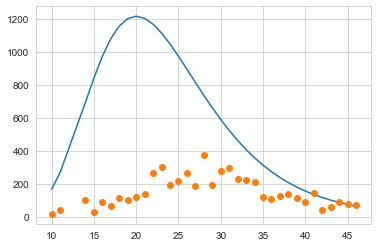

 final_simplex: (array([[ 8.69528229, 26.35005953,  0.10870408],
       [ 8.69528922, 26.35014078,  0.10870332],
       [ 8.69528842, 26.3501081 ,  0.10870301],
       [ 8.69528193, 26.35009776,  0.10870353]]), array([5.37802935, 5.37803459, 5.37803793, 5.37804174]))
           fun: 5.3780293464660645
       message: 'Optimization terminated successfully.'
          nfev: 156
           nit: 79
        status: 0
       success: True
             x: array([ 8.69528229, 26.35005953,  0.10870408])


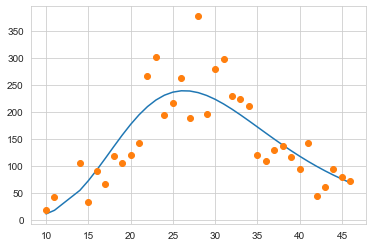

In [197]:
import jax.numpy as np
from jax import grad, jit, vmap, hessian
import jax.scipy as scipy

def gompertz(x, a, b, c):
    """
    Gompertz growth model. 
    
    Proposed in Zwietering et al., 1990 (PMID: 16348228) 
    """
    a = np.exp(a)
    y = a * np.exp(-np.exp( -c*(x-b) ))
    return y
gompertz_prime = vmap(grad(gompertz),(0,None,None,None),(0))

def predict(params, inputs):
    outputs = gompertz(inputs, *params)
    return outputs


def predict_cum(params, inputs):
    outputs = gompertz(inputs, *params)
    return outputs

def predict_daily(params, inputs):
    outputs = gompertz_prime(inputs, *params)
    return outputs


def logprob_fun(params, inputs, targets):
    preds = predict_daily(params, inputs)
    negloglk = ((preds - targets)/targets)**2
    return np.mean(negloglk)

def minuslk_poisson(params, inputs, targets):
    preds = predict_daily(params, inputs)
    negloglk = preds-targets*np.log(preds)+scipy.special.gammaln(targets)
    return np.mean(negloglk)


grad_fun = jit(grad(logprob_fun))  # compiled gradient evaluation function
perex_grads = jit(vmap(grad_fun,
                       in_axes=(None, 0, 0)))  # fast per-example grads

f = lambda z:minuslk_poisson(z,x,y)
curve = gompertz_prime
params = np.array([10, 20, .15],dtype='float32')
plt.plot(x,curve(x,*params))
plt.plot(x,y,'.')
plt.show()
sol = minimize(f, x0 = params,method='Nelder-Mead'  )
print(sol)
params = sol.x
plt.plot(x,curve(x,*params))
plt.plot(x,y,'.')

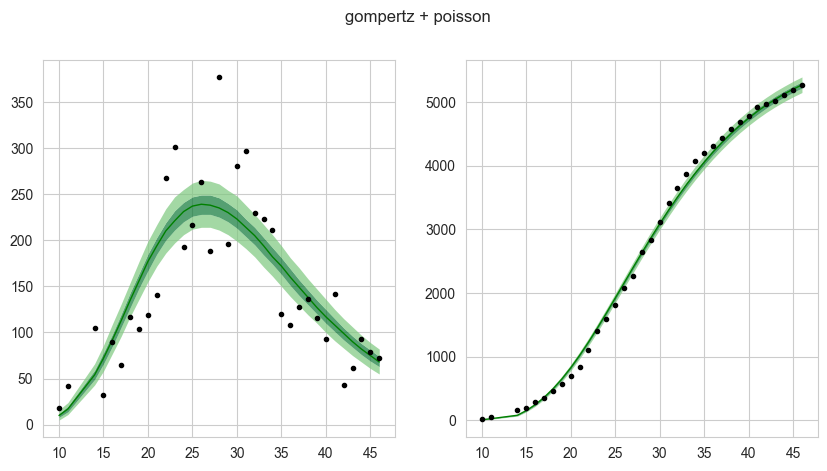

In [314]:
from covid_simulation.plot_utils import plot_prediction_with_uncertainty
from covid_simulation.noise.noise import get_quantiles
import scipy.stats

nruns = 5000

params = [ 8.69528229, 26.35005953,  0.10870408]
mu = predict_daily(params, x).reshape((-1,1))
    

runs = scipy.stats.poisson(mu=mu).rvs(size=(35,nruns))

plt.subplots(1,2,dpi=100, figsize=(10,5))
plt.subplot(1,2,1)
quan, median = get_quantiles(runs, axis=1)
plot_prediction_with_uncertainty(x, median, quan)
plt.plot(x, y, '.', color="black")
plt.subplot(1,2,2)
quan, median = get_quantiles(runs.cumsum(axis=0), axis=1)
plot_prediction_with_uncertainty(x, median, quan)
plt.plot(x, y.cumsum(), '.', color="black")
plt.suptitle('gompertz + poisson')
plt.show()

### negative binomial

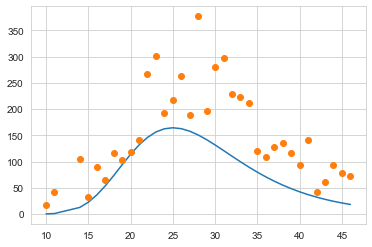

 final_simplex: (array([[ 8.69920049, 26.47877687,  0.10757108,  3.66477828],
       [ 8.69919447, 26.478748  ,  0.10757115,  3.66478714],
       [ 8.69919684, 26.47876864,  0.10757058,  3.66485426],
       [ 8.69920367, 26.47876392,  0.10757055,  3.6648619 ],
       [ 8.6991996 , 26.47874464,  0.10757078,  3.66480725]]), array([5.14260054, 5.14261675, 5.14262581, 5.14262676, 5.14263916]))
           fun: 5.1426005363464355
       message: 'Optimization terminated successfully.'
          nfev: 263
           nit: 139
        status: 0
       success: True
             x: array([ 8.69920049, 26.47877687,  0.10757108,  3.66477828])


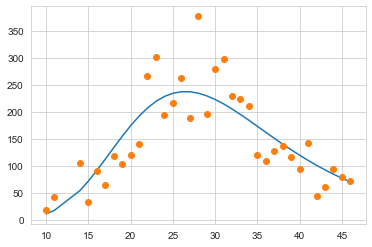

In [258]:
import jax.numpy as np
from jax import grad, jit, vmap, hessian
import jax.scipy as scipy

def gompertz(x, a, b, c):
    """
    Gompertz growth model. 
    
    Proposed in Zwietering et al., 1990 (PMID: 16348228) 
    """
    a = np.exp(a)
    y = a * np.exp(-np.exp( -c*(x-b) ))
    return y
gompertz_prime = vmap(grad(gompertz),(0,None,None,None),(0))


def predict_daily(params, inputs):
    params_g = params[:3]
    outputs = gompertz_prime(inputs, *params_g)
    return outputs




def minuslk_nb(params, inputs, targets):
    
    preds = predict_daily(params, inputs)
    mu = preds
    sigma_rel = params[-1]
    sigma_rel = np.log(1+np.exp(sigma_rel))
    sigma = np.sqrt(mu)*sigma_rel
    
    
    p = np.clip(1-mu/sigma**2,0,1)
    r = mu**2/(sigma**2-mu)
    k = targets
    
    
    negloglk = (scipy.special.gammaln(k+1)+scipy.special.gammaln(r)-scipy.special.gammaln(r+k) 
                    -r* np.log(1-p)-k*np.log(p))
    return np.mean(negloglk)


grad_fun = jit(grad(logprob_fun))  # compiled gradient evaluation function
perex_grads = jit(vmap(grad_fun,
                       in_axes=(None, 0, 0)))  # fast per-example grads

f = lambda z:minuslk_nb(z,x,y)

params = np.array([8, 25, .15,.8],dtype='float32')
plt.plot(x,predict_daily(params,x))
plt.plot(x,y,'.')
plt.show()
sol = minimize(f, x0 = params,method='Nelder-Mead'  )
print(sol)
params = sol.x
plt.plot(x,predict_daily(params,x))
plt.plot(x,y,'.')

(35, 1)
(35, 1)


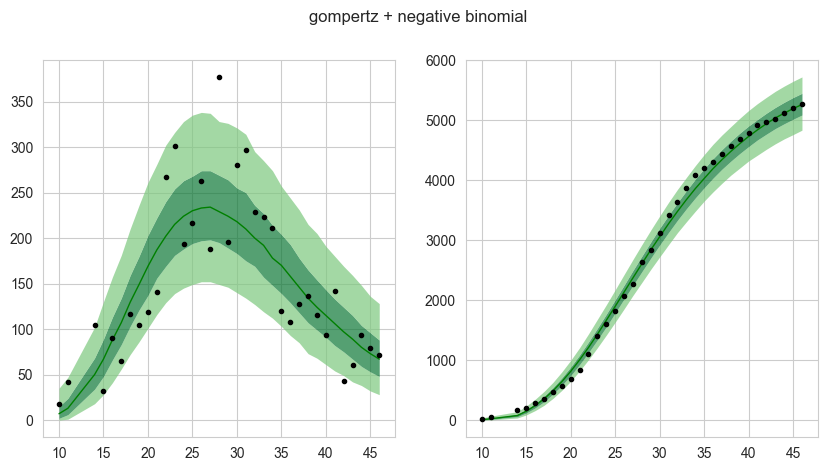

In [313]:
from covid_simulation.plot_utils import plot_prediction_with_uncertainty
from covid_simulation.noise.noise import get_quantiles
import scipy.stats

nruns = 5000

params = [ 8.69920049, 26.47877687,  0.10757108,  3.66477828]
mu = predict_daily(params, x).reshape((-1,1))
    
sigma_rel = params[-1]
sigma_rel = np.log(1+np.exp(sigma_rel))

sigma = np.sqrt(mu)*sigma_rel


p = np.clip(1-mu/sigma**2,0,1).reshape((-1,1))
r = mu**2/(sigma**2-mu).reshape((-1,1))
print(p.shape)
print(r.shape)

runs = scipy.stats.nbinom(n=r,p=1-p).rvs(size=(35,nruns))


plt.subplots(1,2,dpi=100, figsize=(10,5))
plt.subplot(1,2,1)
quan, median = get_quantiles(runs, axis=1)
plot_prediction_with_uncertainty(x, median, quan)
plt.plot(x, y, '.', color="black")
plt.subplot(1,2,2)
quan, median = get_quantiles(runs.cumsum(axis=0), axis=1)
plot_prediction_with_uncertainty(x, median, quan)
plt.plot(x, y.cumsum(), '.', color="black")
plt.suptitle('gompertz + negative binomial')
plt.show()

### normal with absolute sigma

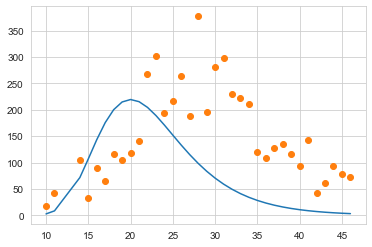

 final_simplex: (array([[ 8.63705629, 26.71842639,  0.12629057, 62.34960701],
       [ 8.63705659, 26.71842973,  0.12629058, 62.34955498],
       [ 8.63705655, 26.71843057,  0.12629058, 62.34957816],
       [ 8.63705658, 26.7184298 ,  0.12629059, 62.3495826 ],
       [ 8.63705612, 26.7184272 ,  0.12629062, 62.34958773]]), array([4.63228989, 4.63229036, 4.63229036, 4.63229084, 4.63229132]))
           fun: 4.632289886474609
       message: 'Optimization terminated successfully.'
          nfev: 249
           nit: 121
        status: 0
       success: True
             x: array([ 8.63705629, 26.71842639,  0.12629057, 62.34960701])


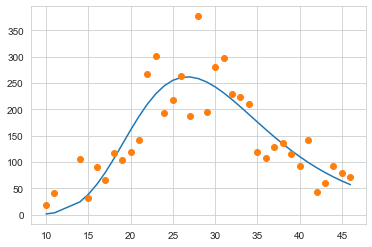

In [175]:
import jax.numpy as np
from jax import grad, jit, vmap, hessian
import jax.scipy as scipy

def gompertz(x, a, b, c):
    """
    Gompertz growth model. 
    
    Proposed in Zwietering et al., 1990 (PMID: 16348228) 
    """
    
    a = np.exp(a)
    y = a * np.exp(-np.exp( -c*(x-b) ))
    return y
gompertz_prime = vmap(grad(gompertz),(0,None,None,None),(0))


def predict_daily(params, inputs):
    a, b, c = params[:3]
    outputs = gompertz_prime(inputs, a, b, c)
    return outputs


def logprob_fun(params, inputs, targets):
    preds = predict_daily(params, inputs)
    sigma = params[-1]
    negloglk = ((preds - targets)/sigma)**2+np.log(sigma**2)/2
    return np.mean(negloglk)



grad_fun = jit(grad(logprob_fun))  # compiled gradient evaluation function



f = lambda z:logprob_fun(z,x,y)
curve = gompertz_prime
params = np.array([ 8, 20,  .20, 10],dtype='float32')
plt.plot(x,predict_daily(params,x))
plt.plot(x,y,'.')
plt.show()
sol = minimize(f, x0 = params,method='Nelder-Mead'  )
print(sol)
params = sol.x
plt.plot(x,predict_daily(params,x))
plt.plot(x,y,'.')

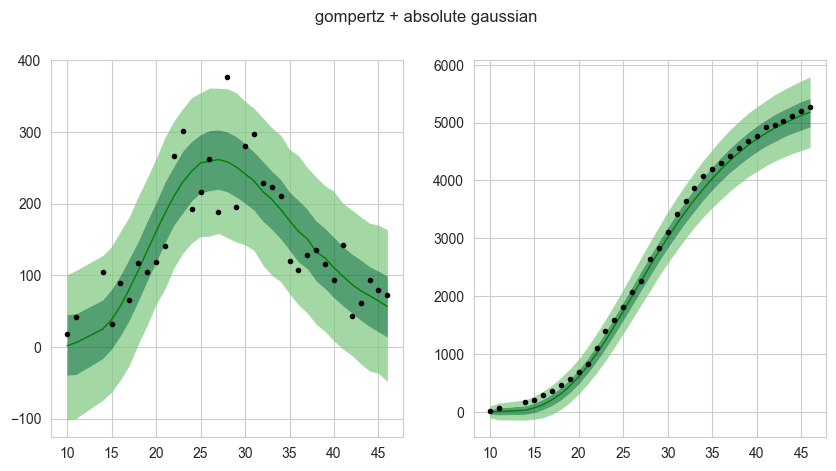

In [312]:
from covid_simulation.plot_utils import plot_prediction_with_uncertainty
from covid_simulation.noise.noise import get_quantiles
import scipy.stats

nruns = 5000

params = [ 8.63705629, 26.71842639,  0.12629057, 62.34960701]
mu = predict_daily(params, x).reshape((-1,1))
sigma = params[-1]

runs = scipy.stats.norm(loc=mu,scale=sigma).rvs(size=(35,nruns))


plt.subplots(1,2,dpi=100, figsize=(10,5))
plt.subplot(1,2,1)
quan, median = get_quantiles(runs, axis=1)
plot_prediction_with_uncertainty(x, median, quan)
plt.plot(x, y, '.', color="black")
plt.subplot(1,2,2)
quan, median = get_quantiles(runs.cumsum(axis=0), axis=1)
plot_prediction_with_uncertainty(x, median, quan)
plt.plot(x, y.cumsum(), '.', color="black")
plt.suptitle('gompertz + absolute gaussian')
plt.show()

### normal with relative sigma

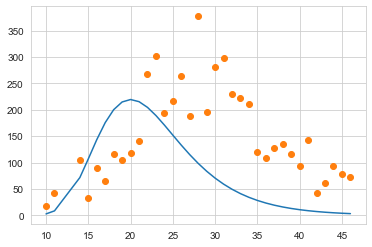

 final_simplex: (array([[ 8.69020629, 25.68420608,  0.1033313 ,  0.45235791],
       [ 8.69020741, 25.68425099,  0.10333061,  0.45236083],
       [ 8.69020534, 25.68424342,  0.10333071,  0.45235701],
       [ 8.69020827, 25.684259  ,  0.1033309 ,  0.45235739],
       [ 8.69020398, 25.68428923,  0.10333049,  0.45235713]]), array([4.58010244, 4.58010244, 4.58010244, 4.58010244, 4.58010292]))
           fun: 4.580102443695068
       message: 'Optimization terminated successfully.'
          nfev: 299
           nit: 165
        status: 0
       success: True
             x: array([ 8.69020629, 25.68420608,  0.1033313 ,  0.45235791])


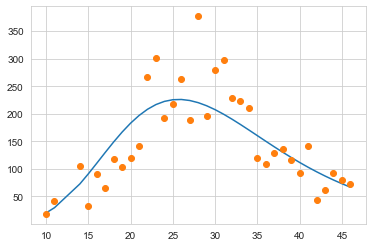

In [196]:
import jax.numpy as np
from jax import grad, jit, vmap, hessian
import jax.scipy as scipy

def gompertz(x, a, b, c):
    """
    Gompertz growth model. 
    
    Proposed in Zwietering et al., 1990 (PMID: 16348228) 
    """
    
    a = np.exp(a)
    y = a * np.exp(-np.exp( -c*(x-b) ))
    return y
gompertz_prime = vmap(grad(gompertz),(0,None,None,None),(0))


def predict_daily(params, inputs):
    a, b, c = params[:3]
    outputs = gompertz_prime(inputs, a, b, c)
    return np.maximum(outputs,0)


def logprob_fun(params, inputs, targets):
    preds = predict_daily(params, inputs)
    sigma = params[-1]*preds
    negloglk = ((preds - targets)/sigma)**2+np.log(sigma**2)/2
    return np.mean(negloglk)



grad_fun = jit(grad(logprob_fun))  # compiled gradient evaluation function



f = lambda z:logprob_fun(z,x,y)
curve = gompertz_prime
params = np.array([ 8, 20,  .20, 0.1],dtype='float32')
plt.plot(x,predict_daily(params,x))
plt.plot(x,y,'.')
plt.show()
sol = minimize(f, x0 = params,method='Nelder-Mead'  )
print(sol)
params = sol.x
plt.plot(x,predict_daily(params,x))
plt.plot(x,y,'.')

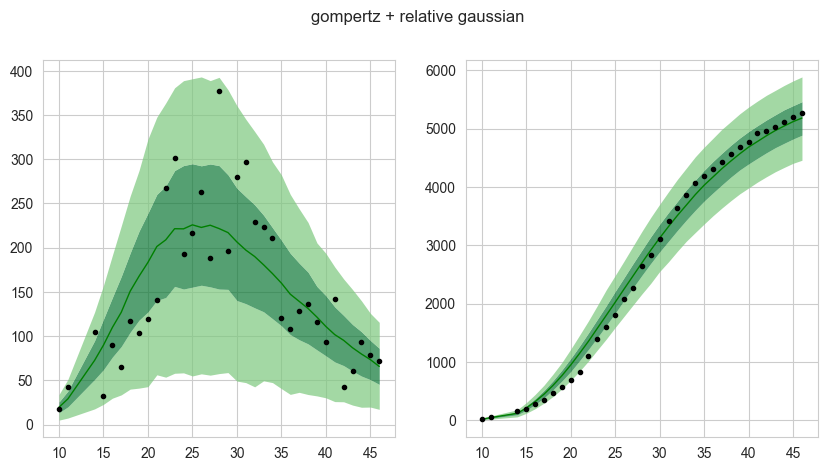

In [311]:
from covid_simulation.plot_utils import plot_prediction_with_uncertainty
from covid_simulation.noise.noise import get_quantiles
import scipy.stats

nruns = 5000

params = [ 8.69020629, 25.68420608,  0.1033313 ,  0.45235791]
mu = predict_daily(params, x).reshape((-1,1))
sigma = params[-1]*mu
runs = scipy.stats.norm(loc=mu,scale=sigma).rvs(size=(35,nruns))

plt.subplots(1,2,dpi=100, figsize=(10,5))
plt.subplot(1,2,1)
quan, median = get_quantiles(runs, axis=1)
plot_prediction_with_uncertainty(x, median, quan)
plt.plot(x, y, '.', color="black")
plt.subplot(1,2,2)
quan, median = get_quantiles(runs.cumsum(axis=0), axis=1)
plot_prediction_with_uncertainty(x, median, quan)
plt.plot(x, y.cumsum(), '.', color="black")
plt.suptitle('gompertz + relative gaussian')
plt.show()

### poisson with normal noise during training, it does not fit well the sigma

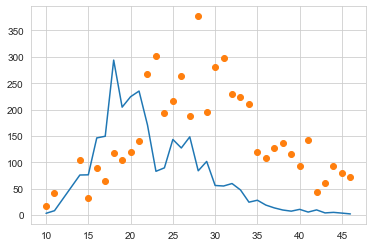

 final_simplex: (array([[ 8.6003762 , 24.68347475,  0.11385079,  0.2285072 ],
       [ 8.6003762 , 24.68347475,  0.11385079,  0.2285072 ],
       [ 8.6003762 , 24.68347475,  0.11385079,  0.2285072 ],
       [ 8.6003762 , 24.68347475,  0.11385079,  0.2285072 ],
       [ 8.6003762 , 24.68347475,  0.11385079,  0.2285072 ]]), array([ 5.197155  ,  7.50271845,  8.95174122, 11.82892418, 14.3149662 ]))
           fun: 5.197154998779297
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 804
           nit: 303
        status: 1
       success: False
             x: array([ 8.6003762 , 24.68347475,  0.11385079,  0.2285072 ])


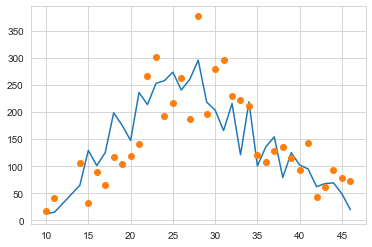

In [193]:
import jax.numpy as np
from jax import grad, jit, vmap, hessian
import jax.scipy as scipy
import jax.random


seed = 0

def gompertz(x, a, b, c):
    """
    Gompertz growth model. 
    
    Proposed in Zwietering et al., 1990 (PMID: 16348228) 
    """
    
    a = np.exp(a)
    y = a * np.exp(-np.exp( -c*(x-b) ))
    return y
gompertz_prime = vmap(grad(gompertz),(0,None,None,None),(0))


def predict_daily(params, inputs):
    global seed
    seed += 1
    key = jax.random.PRNGKey(seed)
    a, b, c = params[:3]
    sigma = params[-1]
    outputs = gompertz_prime(inputs, a, b, c)
    outputs = np.maximum(outputs,0)
    noise = outputs*sigma*jax.random.normal(key, shape=inputs.shape)
    return outputs+noise


def logprob_fun(params, inputs, targets):
    preds = predict_daily(params, inputs)
    sigma = params[-1]*preds
    negloglk = ((preds - targets)/sigma)**2+np.log(sigma**2)/2
    return np.mean(negloglk)

def minuslk_poisson(params, inputs, targets):
    preds = predict_daily(params, inputs)
    negloglk = preds-targets*np.log(preds)+scipy.special.gammaln(targets)
    return np.mean(negloglk)

grad_fun = jit(grad(logprob_fun))  # compiled gradient evaluation function



f = lambda z:minuslk_poisson(z,x,y)
curve = gompertz_prime
params = np.array([ 8, 20,  .20, .2],dtype='float32')
plt.plot(x,predict_daily(params,x))
plt.plot(x,y,'.')
plt.show()
sol = minimize(f, x0 = params,method='Nelder-Mead'  )
print(sol)
params = sol.x
plt.plot(x,predict_daily(params,x))
plt.plot(x,y,'.')

## otros ajustes

In [47]:
import jax.numpy as np
from jax import grad, jit, vmap, hessian


def gompertz(x, a, b, c):
    """
    Gompertz growth model. 
    
    Proposed in Zwietering et al., 1990 (PMID: 16348228) 
    """
    y = a * np.exp(-b*np.exp( -c*t ))
    return y


def predict(params, inputs):
    ps = params[:-1]
    outputs = gompertz(inputs, *ps)
    return outputs


def logprob_fun(params, inputs, targets):
    preds = predict(params, inputs)
    sigma = params[-1]
    negloglk = (preds - targets)**2 / (sigma * preds)**2 + np.log(
        (sigma * preds)**2) / 2
    return np.mean(negloglk)


grad_fun = jit(grad(logprob_fun))  # compiled gradient evaluation function
perex_grads = jit(vmap(grad_fun,
                       in_axes=(None, 0, 0)))  # fast per-example grads

In [48]:
hess = jit(hessian(logprob_fun))

In [49]:
hess(params,x,y).shape

NameError: name 'params' is not defined

In [225]:
f = lambda z:logprob_fun(z,x,y)
jac = lambda z : grad_fun(z,x,y)
hes = lambda z : hess(z,x,y)
params = np.array([6.8074814e+03, 6.2069067e+02, 1.8554901e+01, 2.0514156e-01],dtype='float32')
sol = minimize(f, x0 = params,jac=jac, hess=hes,method='Newton-CG'  )
sol

     fun: 5.732676029205322
     jac: DeviceArray([-3.4126360e-06,  2.3327834e-06,  6.2821994e-07,
             -9.0599060e-06], dtype=float32)
 message: 'Warning: Desired error not necessarily achieved due to precision loss.'
    nfev: 180
    nhev: 40
     nit: 39
    njev: 206
  status: 2
 success: False
       x: DeviceArray([1.1493863e+04, 8.2882971e+02, 2.1313293e+01, 1.6531792e-01],            dtype=float32)

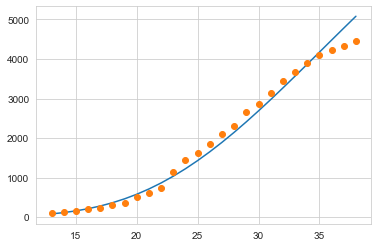

In [226]:
params = sol.x
plt.plot(x,gompertz(x,*params[:-1]))
plt.plot(x,y,'.')

In [146]:
model = gompertz_simple
best_params = fit_model(model, x[:-5], y[:-5], params0=[10000,1000,20])
best_params = [6800.  ,      727.485 ,     19.313232]
logprob_fun(best_params+[30],x,y)

DeviceArray(-10.326342, dtype=float32)

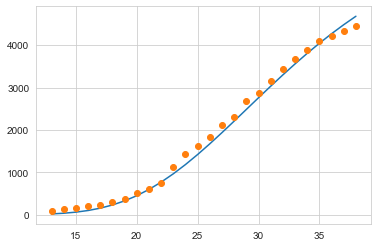

[6800.001     749.99426    19.303917  168.8006  ] [-8.093753e+01  5.747589e+02  6.960837e+04 -1.687956e+07] 
 12.060862
[6800.001     749.99426    19.305824  168.8006  ] [ 1.2544084e-04  1.9595803e-04 -2.0875885e-01  5.9240158e-03] 
 12.060464
[6800.001     749.99426    19.307732  168.8006  ] [ 1.2549479e-04  1.9546870e-04 -2.0880270e-01  5.9240148e-03] 
 12.060067
[6800.001     749.99426    19.309639  168.8006  ] [ 1.2554879e-04  1.9497910e-04 -2.0884657e-01  5.9240139e-03] 
 12.059667
[6800.001     749.99426    19.311546  168.8006  ] [ 1.2560279e-04  1.9448934e-04 -2.0889045e-01  5.9240144e-03] 
 12.05927
[6800.001     749.99426    19.313454  168.8006  ] [ 1.2565682e-04  1.9399935e-04 -2.0893435e-01  5.9240134e-03] 
 12.05887
[6800.001     749.99426    19.315361  168.8006  ] [ 1.2571087e-04  1.9350904e-04 -2.0897824e-01  5.9240130e-03] 
 12.058471
[6800.001     749.99426    19.317268  168.8006  ] [ 1.2576496e-04  1.9301861e-04 -2.0902216e-01  5.9240130e-03] 
 12.058076
[6800.001     

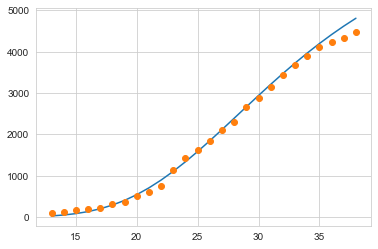

In [219]:
params = np.array([6800,  750,   20,.005],dtype='float32')
plt.plot(x,gompertz(x,*params[:-1]))
plt.plot(x,y,'.')
plt.show()
learning_rate = 0.00001
for i in range(20000):
    grad = grad_fun(params,x,y)
    params -= learning_rate * grad
    if i % 1000 == 0:
        print(params,grad, '\n',logprob_fun(params,x,y))
print(params)
plt.plot(x,gompertz(x,*params[:-1]))
plt.plot(x,y,'.')

In [24]:
def J(X, w, b, y):
    """Cost function for a linear regression. A forward pass of our model.

    Args:
        X: a features matrix.
        w: weights (a column vector).
        b: a bias.
        y: a target vector.

    Returns:
        scalar: a cost of this solution.    
    """
    y_hat = X.dot(w) + b # Predict values.
    return ((y_hat - y)**2).mean() # Return cost.
# A features matrix.
X = np.array([
                 [4., 7.],
                 [1., 8.],
                 [-5., -6.],
                 [3., -1.],
                 [0., 9.]
             ])

# A target column vector.
y = np.array([
                 [37.],
                 [24.],
                 [-34.], 
                 [16.],
                 [21.]
             ])

learning_rate = 0.01

w = np.zeros((2, 1))
b = 0.

grad_X = jit(grad(J, argnums=1))
grad_b = jit(grad(J, argnums=2))

# Run once to trigger JIT compilation.
grad_X(X, w, b, y)
grad_b(X, w, b, y)

for i in range(100):
    w -= learning_rate * grad_X(X, w, b, y)
    b -= learning_rate * grad_b(X, w, b, y)
    
    if i % 10 == 0:
        print(J(X, w, b, y))
        
        
        



/Users/danky/miniconda3/envs/covid/lib/python3.7/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


81.09895
10.8011055
4.6167827
3.2006192
2.3676338
1.7628024
1.3133509
0.9785713
0.72913826
0.54328877
